In [52]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [53]:
# Create a straight line dataset using the linear regression formula (weight * X + bias).
#     Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
#     Split the data into 80% training, 20% testing.
#     Plot the training and testing data so it becomes visual.



weight = 0.9
bias = 0.3

start = 0
end = 20
step = 0.2
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


print(len(X), len(y))
X[:10], y[:10]


100 100


(tensor([[0.0000],
         [0.2000],
         [0.4000],
         [0.6000],
         [0.8000],
         [1.0000],
         [1.2000],
         [1.4000],
         [1.6000],
         [1.8000]]),
 tensor([[0.3000],
         [0.4800],
         [0.6600],
         [0.8400],
         [1.0200],
         [1.2000],
         [1.3800],
         [1.5600],
         [1.7400],
         [1.9200]]))

In [54]:

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [55]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

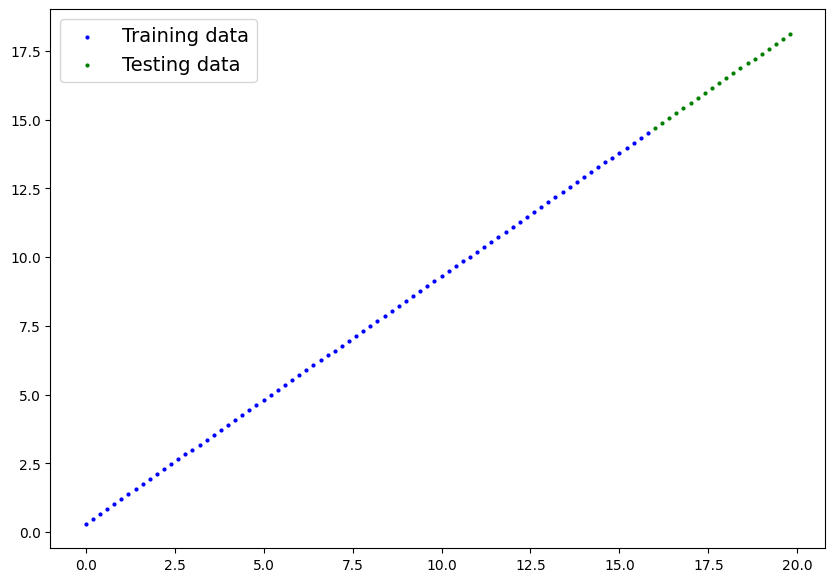

In [56]:
plot_predictions();


In [57]:
# Build a PyTorch model by subclassing nn.Module

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


model = LinearRegressionModel()
model.state_dict()




OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [58]:
# Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
# Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
# Write a training loop to perform the appropriate training steps for 300 epochs.
# The training loop should test the model on the test dataset every 20 epochs.

# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # optimize newly created model's parameters
                            lr=0.001)


torch.manual_seed(42)

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(300):
    ### Training
    model.train()

    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")









Epoch: 0 | Train loss: 4.621336460113525 | Test loss: 10.112022399902344
Epoch: 20 | Train loss: 3.3531365394592285 | Test loss: 7.263822078704834
Epoch: 40 | Train loss: 2.0849366188049316 | Test loss: 4.415622711181641
Epoch: 60 | Train loss: 0.8167368173599243 | Test loss: 1.5674222707748413
Epoch: 80 | Train loss: 0.0400707870721817 | Test loss: 0.05282998085021973
Epoch: 100 | Train loss: 0.03660950809717178 | Test loss: 0.055431462824344635
Epoch: 120 | Train loss: 0.034021295607089996 | Test loss: 0.07181181758642197
Epoch: 140 | Train loss: 0.032884616404771805 | Test loss: 0.10664558410644531
Epoch: 160 | Train loss: 0.030526453629136086 | Test loss: 0.1150762066245079
Epoch: 180 | Train loss: 0.025800716131925583 | Test loss: 0.006635332014411688
Epoch: 200 | Train loss: 0.021277813240885735 | Test loss: 0.03567857667803764
Epoch: 220 | Train loss: 0.030075516551733017 | Test loss: 0.13124661147594452
Epoch: 240 | Train loss: 0.01678052917122841 | Test loss: 0.041470147669315

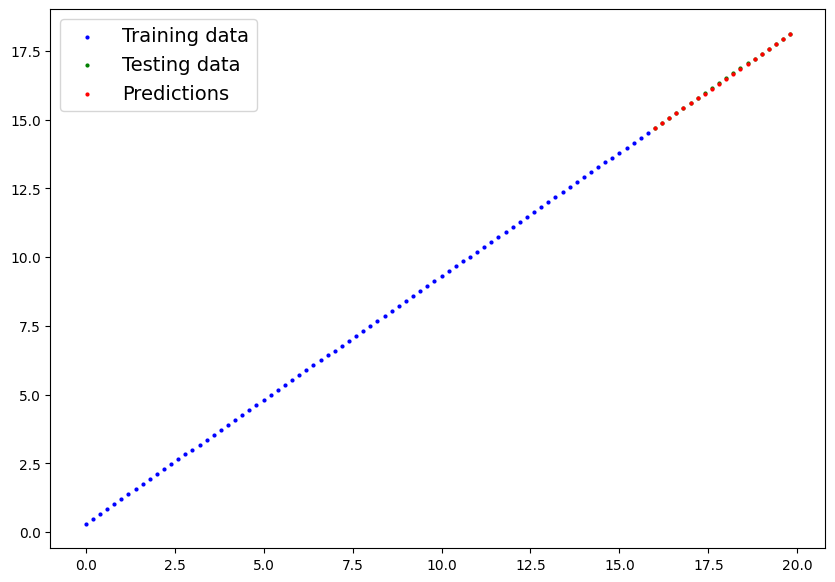

In [60]:
plot_predictions(predictions=test_pred.cpu())

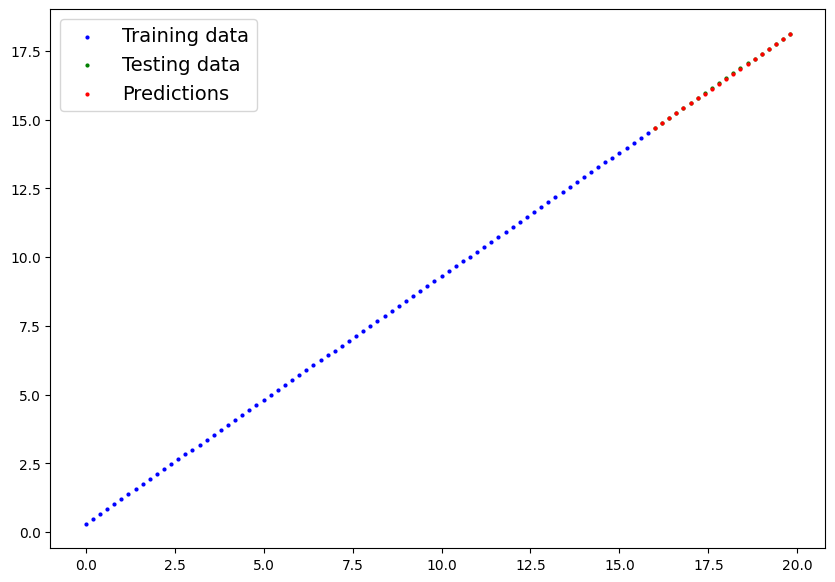

In [65]:
# 4. Make predictions with the trained model on the test data.
# Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).


model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

y_preds
plot_predictions(predictions=y_preds)

In [67]:
# 5. Save your trained model's state_dict() to file.
# Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
# Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_workflow_model-exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model-exercise.pth


In [69]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model = LinearRegressionModel()

# Load model state dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel()
Model on device:
cpu


In [71]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])